<a href="https://colab.research.google.com/github/MarcFriz/Kaggle-Earthquake_challenge/blob/master/Kaggle_Earthquake_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://i.imgur.com/rTadNbm.png)

# Step 1 - Install and Import

In [2]:
#to access kaggle datasets
!pip install kaggle
#Math operations
!pip install numpy
#Machine learning
!pip install catboost
!pip install keras
!pip install xgboost

In [0]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import math

# Step 2 - Import Dataset from Kaggle

In [4]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [5]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [247]:
#unzip training data for usage, will take about 5 minutes (its big)
!ls
# !unzip train.csv.zip
# !unzip test.zip
!ls

catboost_info	       seg_42648c.csv  seg_8456d3.csv  seg_c20c06.csv
mycsvfile.csv	       seg_4280d9.csv  seg_845a2a.csv  seg_c21723.csv
sample_data	       seg_428d66.csv  seg_8472f3.csv  seg_c21d60.csv
sample_submission.csv  seg_42c4c9.csv  seg_848695.csv  seg_c22bd4.csv
seg_00030f.csv	       seg_42e7e8.csv  seg_84a65d.csv  seg_c23429.csv
seg_0012b5.csv	       seg_42ff14.csv  seg_84b9d9.csv  seg_c23641.csv
seg_00184e.csv	       seg_430e66.csv  seg_84c7fb.csv  seg_c243a6.csv
seg_003339.csv	       seg_43383f.csv  seg_84fc12.csv  seg_c24946.csv
seg_0042cc.csv	       seg_434c96.csv  seg_8509db.csv  seg_c25855.csv
seg_004314.csv	       seg_43597f.csv  seg_850d95.csv  seg_c267a5.csv
seg_004cd2.csv	       seg_43c6f4.csv  seg_8515fd.csv  seg_c26fb4.csv
seg_004ee5.csv	       seg_440106.csv  seg_853302.csv  seg_c27591.csv
seg_004f1f.csv	       seg_4401d8.csv  seg_854d91.csv  seg_c2a0c8.csv
seg_00648a.csv	       seg_441c6d.csv  seg_857304.csv  seg_c2b8f7.csv
seg_006e4a.csv	       seg_4435bd.csv  

# Step 3 -  Exploratory Data Analysis

In [0]:

#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [249]:
#print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


(60000,)


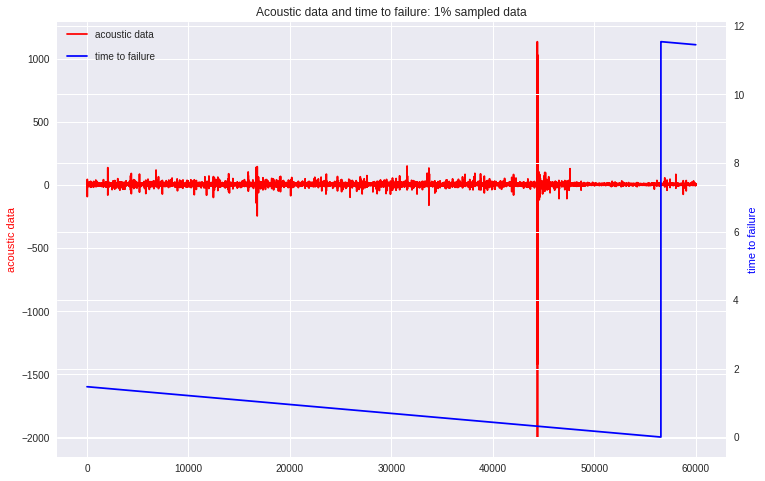

In [250]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

print(train_ad_sample_df.shape)

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

# Step 4 - Feature Engineering

In [0]:
#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [253]:
X_train.describe()

,0,1,2,3,4,5,6,7,8
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,5515.000000,32.762073,150.432368


In [254]:
X_train.shape

(4195, 9)

In [255]:
X_train.size

37755

In [0]:
from sklearn.model_selection import train_test_split

X_lstm_train = X_train.copy()
y_lstm_train = y_train.copy()
original_X = X_train.copy()
original_y = y_train.copy()

X_test = X_train.copy()
y_test = y_train.copy()

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

# Step 5 - Implement Catboost Model

In [257]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
with tf.device('/gpu:0'):
  train_pool = Pool(X_train, y_train)
  m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
  m.fit(original_X, original_y, silent=True)
#   m.fit(X_train, y_train, silent=True)
  m.best_score_

In [259]:
metrics.mean_absolute_error(y_test, m.predict(X_test))

1.7976107166873287

# Step 6 - Implement XGBoost

In [260]:
import xgboost as xgb

with tf.device('/gpu:0'):
  gbm = xgb.XGBRegressor()
  reg_cv = GridSearchCV(gbm, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
                              ,'max_depth': [3,4], 'n_estimators': [500,1000]}, verbose=1)
  reg_cv.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   32.7s finished


In [261]:
reg_cv.best_params_

{'colsample_bytree': 1.0,
 'max_depth': 3,
 'min_child_weight': 1.0,
 'n_estimators': 500}

In [0]:
with tf.device('/gpu:0'):
  gbm = xgb.XGBRegressor(**reg_cv.best_params_)
  gbm.fit(X_train,y_train, eval_metric='mae')
  metrics.mean_absolute_error(y_train, gbm.predict(X_train))

In [263]:
metrics.mean_absolute_error(y_test, gbm.predict(X_test))

1.641375677361558

# Step 7 - Implement Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor

with tf.device('/gpu:0'):
  regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
  regr.fit(X_train, y_train)
  metrics.mean_absolute_error(y_train, regr.predict(X_train))

In [265]:
metrics.mean_absolute_error(y_test, regr.predict(X_test))

2.3251807829604028

# Step 8 - Implement SGD

In [0]:
from sklearn import linear_model

with tf.device('/gpu:0'):
  clf = linear_model.SGDRegressor(max_iter=1000, tol=1e-3)
  clf.fit(X_train, y_train)
  metrics.mean_absolute_error(y_train, clf.predict(X_train))

In [267]:
metrics.mean_absolute_error(y_test, clf.predict(X_test))

42022388093586.92

# Step 9 - Implement Ridg Regression

In [0]:
with tf.device('/gpu:0'):
  reg = linear_model.Ridge(alpha=.5)
  reg.fit(X_train, y_train)
  metrics.mean_absolute_error(y_train, clf.predict(X_train))

In [269]:
metrics.mean_absolute_error(y_test, clf.predict(X_test))

42022388093586.92

# Step 10 - Implement Lasso

In [270]:
with tf.device('/gpu:0'):
  regLasso = linear_model.Lasso(alpha=0.1)
  regLasso.fit(X_train, y_train)
  metrics.mean_absolute_error(y_train, regLasso.predict(X_train))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [271]:
metrics.mean_absolute_error(y_test, regLasso.predict(X_test))

2.578952630180003

# Step 11 - Implement KernelRidge

In [0]:
from sklearn.kernel_ridge import KernelRidge

with tf.device('/gpu:0'):
  krr = KernelRidge(alpha=1.0)
  krr.fit(X_train, y_train)
  metrics.mean_absolute_error(y_train, krr.predict(X_train))

In [273]:
metrics.mean_absolute_error(y_test, krr.predict(X_test))

2.3690607465877385

# Step 12 - Implement DecisionTree

In [0]:
from sklearn import tree

with tf.device('/gpu:0'):
  tree = tree.DecisionTreeRegressor()
  tree.fit(X_train, y_train)
  metrics.mean_absolute_error(y_train, tree.predict(X_train))

In [275]:
metrics.mean_absolute_error(y_test, tree.predict(X_test))

4.999726293210882e-07

# Step 13 - Implement MLPRegressor

In [0]:
from sklearn.neural_network import MLPRegressor, MLPClassifier

with tf.device('/gpu:0'):
  mlp = MLPRegressor(500)
  mlp.fit(X_train, y_train)
  metrics.mean_absolute_error(y_train, mlp.predict(X_train))

In [277]:
metrics.mean_absolute_error(y_test, mlp.predict(X_test))

2.4678900531331514

# Step X - Implement LSTM

In [278]:
X_lstm_train.head()

,0,1,2,3,4,5,6,7,8
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,104.0,5.576567,4.333325
1,4.725767,6.588824,-154.0,181.0,98.758517,0.390561,181.0,5.734167,5.732777
2,4.906393,6.967397,-106.0,140.0,33.555211,0.217391,140.0,6.152647,5.895945
3,4.902240,6.922305,-199.0,197.0,116.548172,0.757278,199.0,5.933960,6.061214
4,4.908720,7.301110,-126.0,145.0,52.977905,0.064531,145.0,6.110587,6.329485


In [279]:
tmp =X_lstm_train.shape[0] / 100
f=math.floor(tmp)

minus = (tmp - f) * 100 
minus = int(minus)

print(minus)
print(f)

95
41


In [280]:
X_lstm_train.shape

(4195, 9)

In [281]:
print(X_lstm_train.size)
new = X_lstm_train[:-95]
print(new.size)
s = new.as_matrix()
s = s.reshape(f, 100, 9)
s.shape

37755
36900


(41, 100, 9)

In [282]:
d = y_lstm_train[:-95]
d = d.reshape(f,100)
d.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


(41, 100)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras import losses

import keras

In [284]:
lstm_out = 200

with tf.device('/gpu:0'):
  model = Sequential()
  model.add(LSTM(lstm_out, input_shape=(100,9), dropout_U = 0.002, dropout_W = 0.002, return_sequences=False))
  # model.add(LSTM(lstm_out, input_shape=(100,9), dropout_U = 0.002, dropout_W = 0.002))
  model.add(Dense(100,activation='relu'))
  adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(loss=keras.losses.mean_absolute_error , optimizer=adam, metrics = ['mae', 'acc'])
  print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, input_shape=(100, 9), return_sequences=False, dropout=0.002, recurrent_dropout=0.002)`
  """


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200)               168000    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
Total params: 188,100
Trainable params: 188,100
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
with tf.device('/gpu:0'):
  model.fit(s, d, nb_epoch = 2000)

In [286]:
metrics.mean_absolute_error(d, model.predict(s))

1.1358337594354893

# Test Data

In [0]:
# !ls
# test = pd.read_csv('seg_00030f.csv', dtype={'acoustic_data': np.int16})
test = pd.read_csv('seg_0012b5.csv')

In [0]:
test

In [0]:
X_pred = pd.DataFrame()
# y_train = pd.Series()
# for df in train:
ch = gen_features(test['acoustic_data'])
X_pred = X_pred.append(ch, ignore_index=True)
#     y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [290]:
X_pred

,0,1,2,3,4,5,6,7,8
0,4.171153,5.922839,-140.0,152.0,56.218955,0.295708,152.0,5.19834,5.045369


In [291]:
# m.predict(X_pred)

array([4.77152603])

In [0]:
import glob

files = []

for filename in glob.glob('seg_*'):
  files.append(filename)

In [0]:
all = {}

for filename in files:
  test = pd.read_csv(filename)
  X_pred = pd.DataFrame()
  ch = gen_features(test['acoustic_data'])
  X_pred = X_pred.append(ch, ignore_index=True)
#   erg = m.predict(X_pred)
  erg = gbm.predict(X_pred)
  all[filename] = erg

In [0]:
all

In [0]:
sample = pd.read_csv('sample_submission.csv')
sample

In [0]:
import os
os.getcwd()

In [0]:
import csv

with open('XGBoost.csv', 'w') as f:
    for key in all.keys():
        f.write("%s,%s\n"%(key,all[key]))

In [0]:
from google.colab import files
files.download('XGBoost.csv')